<a href="https://colab.research.google.com/github/Orurh/Learning/blob/main/%22%5Bhomework%5Ddense_and_convolutional_nn_Shelenko_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

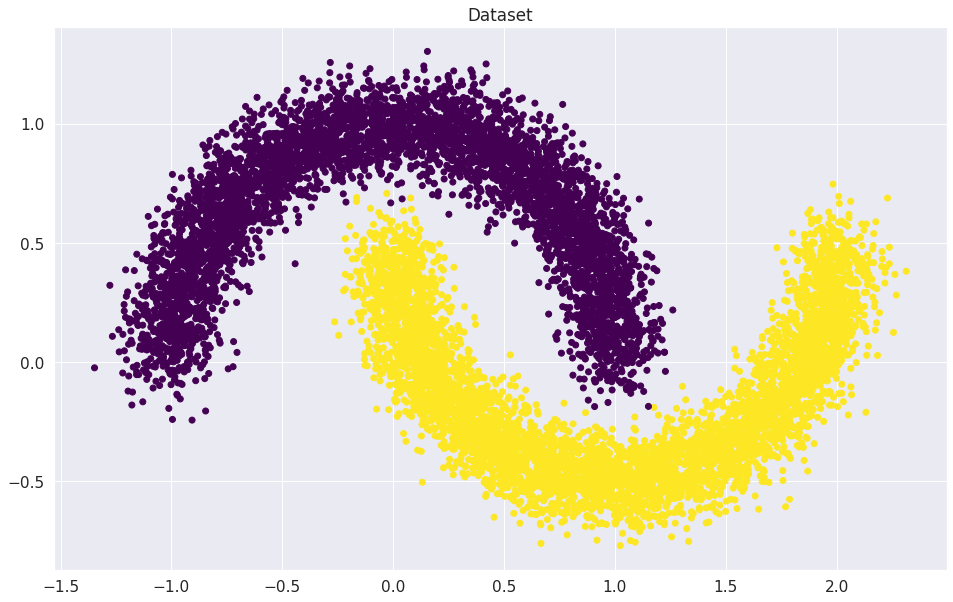

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7500, 2), (2500, 2), (7500,), (2500,))

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

In [6]:
X_train_t.dtype

torch.float32

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term 
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [10]:
sum(p.numel() for p in LinearRegression(2, 1).parameters() if p.requires_grad)

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)# YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.78125
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 

In [12]:
print(f"потребовалось: {it + epoch * len(train_dataloader)} итераций")

потребовалось: 759 итераций


### Визуализируем результаты

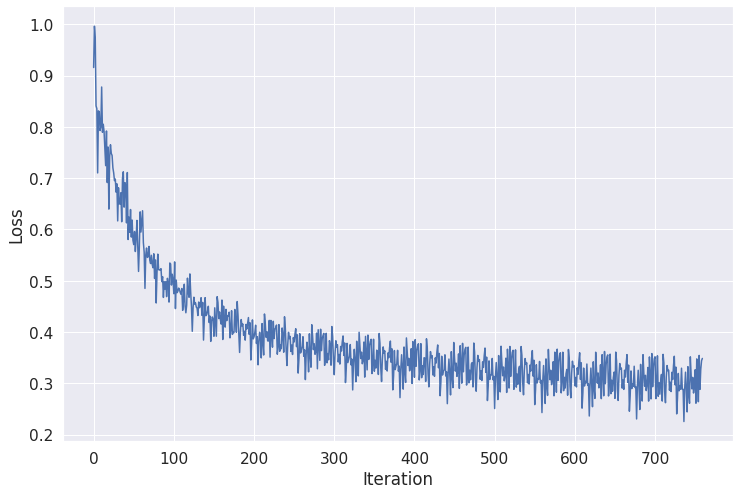

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

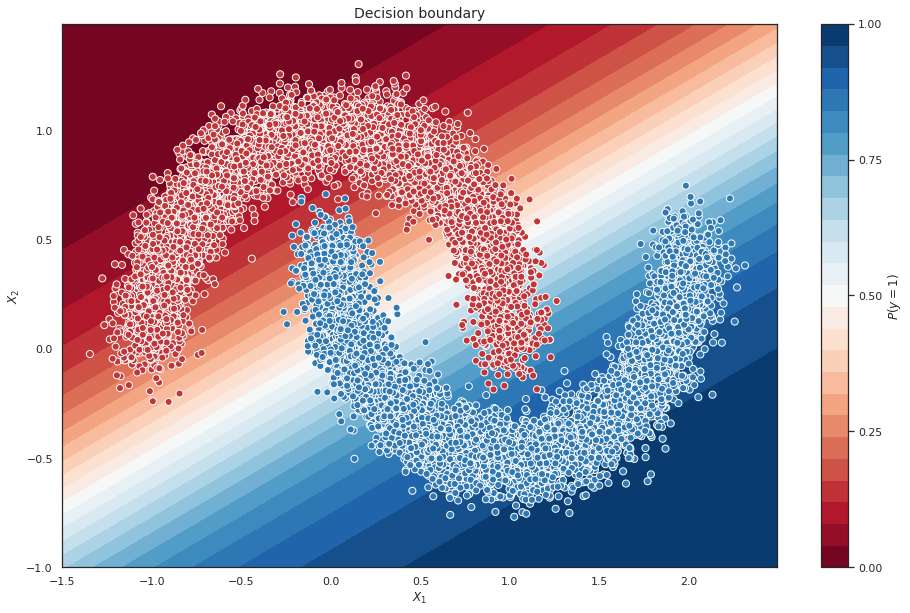

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds=torch.sigmoid(model(x_batch))
        preds=torch.round(preds)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

In [17]:
accuracy_score(y_val_t, predictions)

0.8636

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [18]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                          shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [19]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
torch.cuda.empty_cache()
activation = nn.ELU

In [21]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)#YOUR CODE. Add layers to your sequential class
)

In [22]:
criterion = nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())
max_epochs = 10

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [24]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [25]:
def train_model(model, criterion, optimizer, loaders, max_epochs):  
    accuracy = {"train": [], "valid": []}
    losses = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for batch in dataloader:
                x_batch = batch[0].to(device)
                y_batch = batch[1].to(device)  
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)                
                preds = outp.argmax(-1)
                correct = (0 == abs(preds - y_batch)).sum()
                all = len(x_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()  
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
            losses[k].append(loss.item())
    return model, accuracy, losses

In [26]:
model, accuracy, losses = train_model(model, criterion, optimizer, loaders, max_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.88765
Loader: valid. Accuracy: 0.9364
Epoch: 2
Loader: train. Accuracy: 0.9489666666666666
Loader: valid. Accuracy: 0.9605
Epoch: 3
Loader: train. Accuracy: 0.9641833333333333
Loader: valid. Accuracy: 0.9639
Epoch: 4
Loader: train. Accuracy: 0.9715
Loader: valid. Accuracy: 0.9735
Epoch: 5
Loader: train. Accuracy: 0.9757666666666667
Loader: valid. Accuracy: 0.9726
Epoch: 6
Loader: train. Accuracy: 0.9785666666666667
Loader: valid. Accuracy: 0.9748
Epoch: 7
Loader: train. Accuracy: 0.982
Loader: valid. Accuracy: 0.9742
Epoch: 8
Loader: train. Accuracy: 0.98405
Loader: valid. Accuracy: 0.9767
Epoch: 9
Loader: train. Accuracy: 0.9850333333333333
Loader: valid. Accuracy: 0.9754
Epoch: 10
Loader: train. Accuracy: 0.9867833333333333
Loader: valid. Accuracy: 0.9713


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [27]:
elu_accuracy = accuracy["valid"]

In [29]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    torch.cuda.empty_cache()
    model = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(28*28, 128),
                          activation(),
                          nn.Linear(128, 128),
                          activation(),
                          nn.Linear(128, 10)
                         )

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    model, accuracy, losses = train_model(model, criterion, optimizer, 
                                       loaders, 10)

    return accuracy

In [30]:
print('\n\n !!!Train with activation_function(Identical)!!!')
plain_accuracy = test_activation_function(Identical)['valid']
print('\n\n !!!Train with activation_function(ReLU)!!!')
relu_accuracy = test_activation_function(nn.ReLU)['valid'] #YOUR CODE
print('\n\n !!!Train with activation_function(LeakyReLU)!!!')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)['valid']#YOUR CODE




 !!!Train with activation_function(Identical)!!!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8716
Loader: valid. Accuracy: 0.8843
Epoch: 2
Loader: train. Accuracy: 0.9044
Loader: valid. Accuracy: 0.9118
Epoch: 3
Loader: train. Accuracy: 0.9080666666666667
Loader: valid. Accuracy: 0.9092
Epoch: 4
Loader: train. Accuracy: 0.90985
Loader: valid. Accuracy: 0.9159
Epoch: 5
Loader: train. Accuracy: 0.9113666666666667
Loader: valid. Accuracy: 0.9142
Epoch: 6
Loader: train. Accuracy: 0.9119833333333334
Loader: valid. Accuracy: 0.9127
Epoch: 7
Loader: train. Accuracy: 0.9129666666666667
Loader: valid. Accuracy: 0.9153
Epoch: 8
Loader: train. Accuracy: 0.9147
Loader: valid. Accuracy: 0.9101
Epoch: 9
Loader: train. Accuracy: 0.91465
Loader: valid. Accuracy: 0.915
Epoch: 10
Loader: train. Accuracy: 0.9165166666666666
Loader: valid. Accuracy: 0.9185


 !!!Train with activation_function(ReLU)!!!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8705
Loader: valid. Accuracy: 0.9249
Epoch: 2
Loader: train. Accuracy: 0.9379
Loader: valid. Accuracy: 0.9489
Epoch: 3
Loader: train. Accuracy: 0.9550166666666666
Loader: valid. Accuracy: 0.9576
Epoch: 4
Loader: train. Accuracy: 0.9640166666666666
Loader: valid. Accuracy: 0.9629
Epoch: 5
Loader: train. Accuracy: 0.9697833333333333
Loader: valid. Accuracy: 0.9691
Epoch: 6
Loader: train. Accuracy: 0.97375
Loader: valid. Accuracy: 0.9685
Epoch: 7
Loader: train. Accuracy: 0.9764333333333334
Loader: valid. Accuracy: 0.9691
Epoch: 8
Loader: train. Accuracy: 0.9794833333333334
Loader: valid. Accuracy: 0.9725
Epoch: 9
Loader: train. Accuracy: 0.9806833333333334
Loader: valid. Accuracy: 0.9726
Epoch: 10
Loader: train. Accuracy: 0.9826833333333334
Loader: valid. Accuracy: 0.97


 !!!Train with activation_function(LeakyReLU)!!!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8786833333333334
Loader: valid. Accuracy: 0.9376
Epoch: 2
Loader: train. Accuracy: 0.9428166666666666
Loader: valid. Accuracy: 0.9542
Epoch: 3
Loader: train. Accuracy: 0.9581833333333334
Loader: valid. Accuracy: 0.9628
Epoch: 4
Loader: train. Accuracy: 0.9663166666666667
Loader: valid. Accuracy: 0.9635
Epoch: 5
Loader: train. Accuracy: 0.9726166666666667
Loader: valid. Accuracy: 0.9692
Epoch: 6
Loader: train. Accuracy: 0.9753666666666667
Loader: valid. Accuracy: 0.9705
Epoch: 7
Loader: train. Accuracy: 0.9783333333333334
Loader: valid. Accuracy: 0.9728
Epoch: 8
Loader: train. Accuracy: 0.9818166666666667
Loader: valid. Accuracy: 0.9739
Epoch: 9
Loader: train. Accuracy: 0.98255
Loader: valid. Accuracy: 0.9733
Epoch: 10
Loader: train. Accuracy: 0.9835
Loader: valid. Accuracy: 0.9701


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

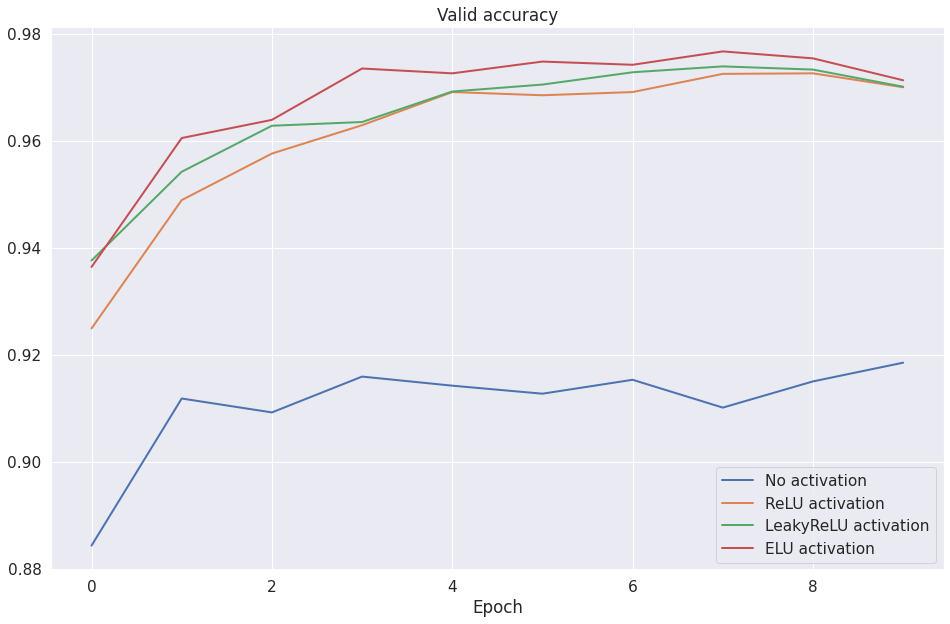

In [31]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

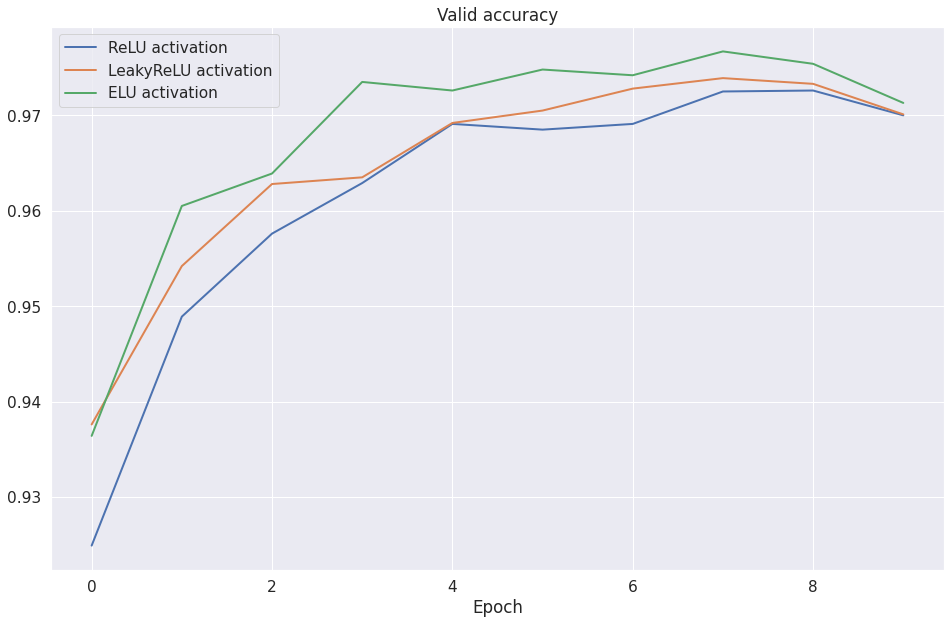

In [32]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ELU**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [33]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-11 18:18:19--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-11 18:18:20--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  92.9KB/s    in 0.5s    

2021-11-11 18:18:22 (92.9 KB/s) - ‘sample_photo.jpg’ saved [49337/

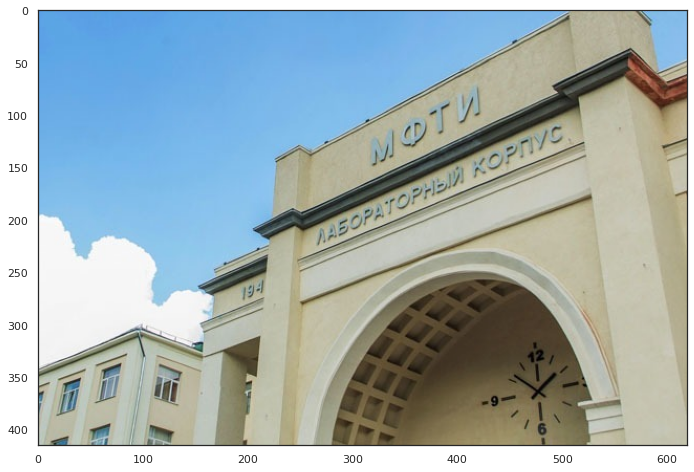

In [34]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [35]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


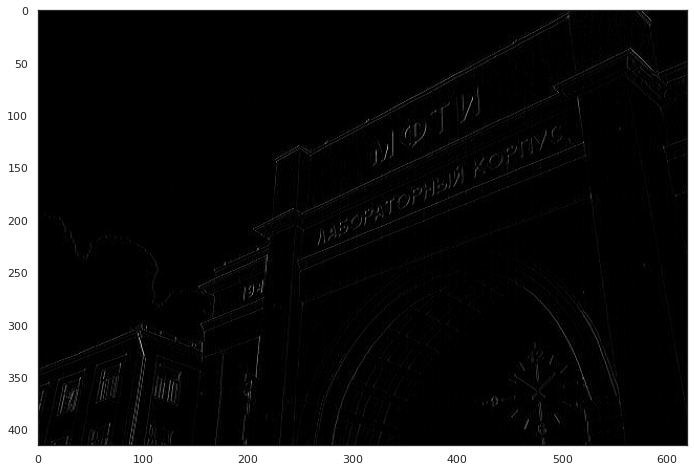

In [36]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [37]:
tensor_filters = [
                  [[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, 0]],

                   [[0, 1, 0],
                   [0, -2, 0],
                   [0, 1, 0]],

                   [[0, 0, 0],
                   [1, -2, 1],
                   [0, 0, 0]],

                   [[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]],

                   [[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]],

                   [[0.0625, 0.125, 0.0625],
                   [0.125, 0.25, 0.125],
                   [0.0625, 0.125, 0.0625]]
                  ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


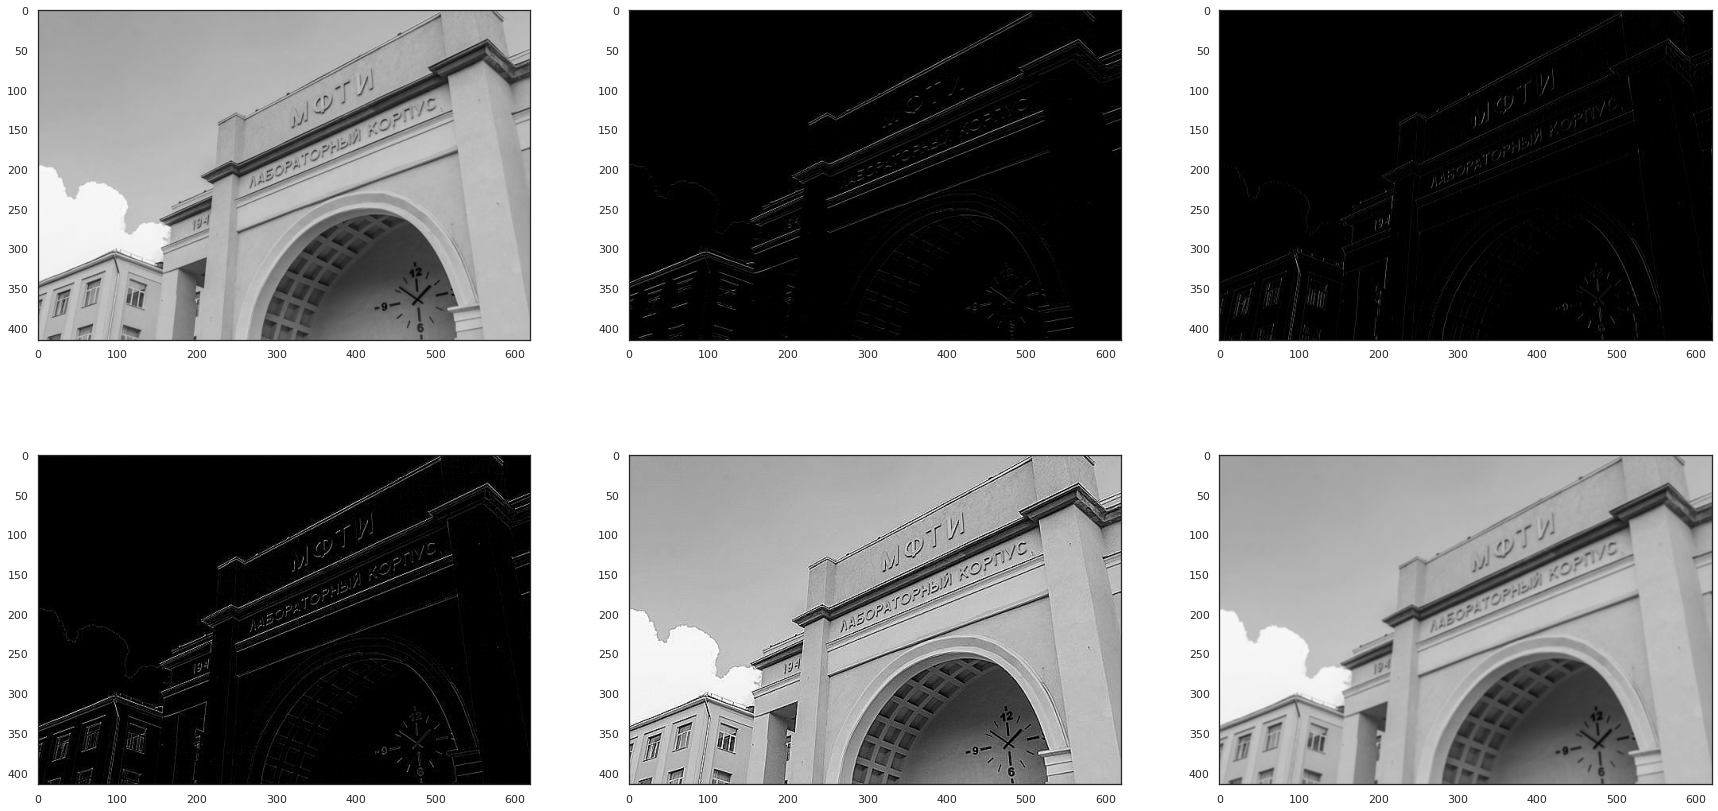

In [38]:
plt.figure(figsize=(30, 15))
for i, tensor_filters in enumerate(tensor_filters):
  img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
  kernel = torch.tensor(tensor_filters).reshape(1, 1, 3, 3).type(torch.float32)

  kernel = kernel.repeat(3, 3, 1, 1)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  result = F.conv2d(img_t, kernel)[0] 

  plt.subplot(2, 3, i+1)
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3

  plt.imshow(result_np);

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

**A - 3; Б - 5; В - 4; Г - 6; Д - 2; Е - 1**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [39]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [40]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [41]:
model, accuracy, losses = train_model(model, criterion, optimizer, loaders, max_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1
Loader: train. Accuracy: 0.8898
Loader: valid. Accuracy: 0.9608
Epoch: 2
Loader: train. Accuracy: 0.9689333333333333
Loader: valid. Accuracy: 0.9784
Epoch: 3
Loader: train. Accuracy: 0.97705
Loader: valid. Accuracy: 0.9807
Epoch: 4
Loader: train. Accuracy: 0.98175
Loader: valid. Accuracy: 0.9852
Epoch: 5
Loader: train. Accuracy: 0.98535
Loader: valid. Accuracy: 0.9855
Epoch: 6
Loader: train. Accuracy: 0.9871
Loader: valid. Accuracy: 0.9884
Epoch: 7
Loader: train. Accuracy: 0.9891333333333333
Loader: valid. Accuracy: 0.9874
Epoch: 8
Loader: train. Accuracy: 0.9901666666666666
Loader: valid. Accuracy: 0.9889
Epoch: 9
Loader: train. Accuracy: 0.9919166666666667
Loader: valid. Accuracy: 0.9878
Epoch: 10
Loader: train. Accuracy: 0.9928333333333333
Loader: valid. Accuracy: 0.9901


In [42]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

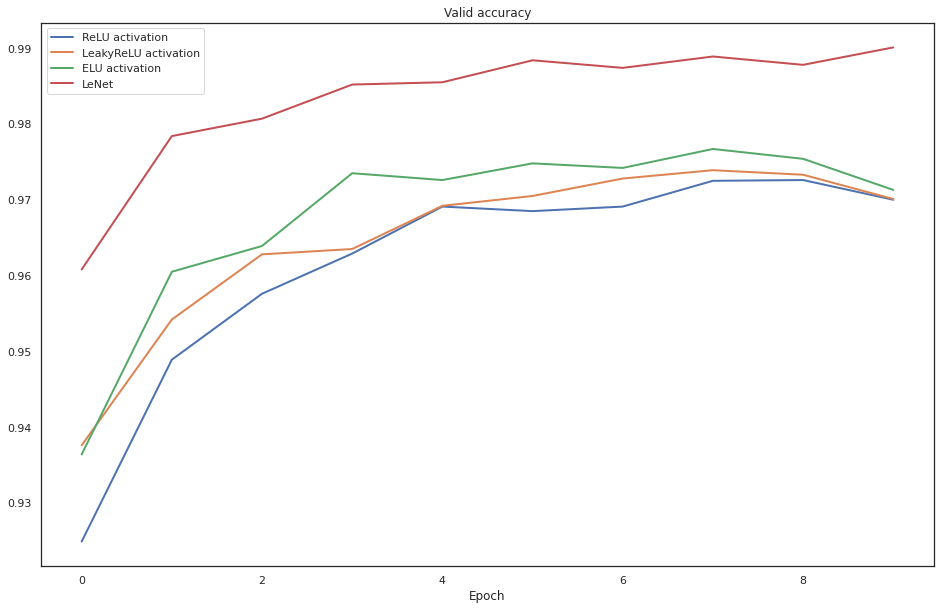

In [43]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [44]:
lenet_accuracy[-1]

0.9901